In [ ]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import time
from pathlib import Path
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import json

# Import del tuo modello
from src.rl.modelling import ViT_UCB_Pruning
from src.data.dataset import PatchFromH5Dataset

In [ ]:


# Configurazione plot
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# %%
# =============================================================================
# CONFIGURAZIONE
# =============================================================================

class BenchmarkConfig:
    """Configurazione centralizzata per il benchmark"""
    
    # Dataset
    DATASET_PATH = '/data/patches/'
    IMG_SIZE = 224
    BATCH_SIZE = 4
    NUM_WORKERS = 8
    
    # Model
    MODEL_NAME = "hf-hub:MahmoodLab/uni"
    NUM_CLASSES = None  # Will be inferred from dataset
    
    # Checkpoint paths - MODIFICA QUESTI CON I TUOI PATH
    CHECKPOINTS = {
        'keep_ratio_0.8': 'results2/keep_ratio_0.8/final_checkpoint/ViT-UCB-Training-keep_ratio-0.8.bin',
    }
    
    # Pruning ratios da testare in INFERENZA
    INFERENCE_KEEP_RATIOS = [ 0.8]
    
    # Benchmark settings
    WARMUP_RUNS = 10
    BENCHMARK_RUNS = 100
    
    # Device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Output
    OUTPUT_DIR = Path("./benchmark_results")
    OUTPUT_DIR.mkdir(exist_ok=True)

config = BenchmarkConfig()

In [ ]:
print("📦 Loading dataset...")

dataset = PatchFromH5Dataset(
    h5_dir=config.DATASET_PATH,
    transform=transforms.Compose([
        transforms.Resize(config.IMG_SIZE),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
)

config.NUM_CLASSES = len(np.unique(dataset.labels))
print(f"✅ Dataset loaded: {len(dataset)} samples, {config.NUM_CLASSES} classes")

In [ ]:
# Crea test set (usa lo stesso split del training)
from sklearn.model_selection import train_test_split

labels = dataset.labels
df = pd.DataFrame({"index": np.arange(len(labels)), "label": labels})
min_count = df["label"].value_counts().min()
undersampled_df = (
    df.groupby("label", group_keys=False)
      .apply(lambda x: x.sample(n=min_count, random_state=42))
      .reset_index(drop=True)
)
undersampled_indices = undersampled_df["index"].sample(frac=1, random_state=42).tolist()
undersampled_labels = [labels[i] for i in undersampled_indices]

trainval_idx, test_idx = train_test_split(
    undersampled_indices, test_size=0.3, stratify=undersampled_labels, random_state=42
)

test_dataset = Subset(dataset, test_idx)
test_loader = DataLoader(
    test_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=False, 
    num_workers=config.NUM_WORKERS, 
    drop_last=False
)

print(f"✅ Test set: {len(test_dataset)} samples")


In [ ]:
def load_checkpoint(checkpoint_path: str, training_keep_ratio: float) -> ViT_UCB_Pruning:
    """Carica un checkpoint del modello"""
    print(f"  Loading checkpoint: {checkpoint_path}")
    
    model = ViT_UCB_Pruning(
        model_name=config.MODEL_NAME,
        pretrained=False,  # Non ricaricare i pesi pretrained
        n_classes=config.NUM_CLASSES,
        keep_ratio=training_keep_ratio,
        exclude_cls=True
    )
    
    # Carica i pesi del checkpoint
    state_dict = torch.load(checkpoint_path, map_location=config.DEVICE)
    model.load_state_dict(state_dict)
    model.to(config.DEVICE)
    model.eval()
    
    print(f"  ✅ Model loaded successfully")
    return model


def evaluate_model(
    model: ViT_UCB_Pruning,
    dataloader: DataLoader,
    inference_keep_ratio: float,
    use_pruned_forward: bool = True
) -> dict:
    """
    Valuta il modello sul dataset
    
    Args:
        model: Modello da valutare
        dataloader: DataLoader per il test set
        inference_keep_ratio: Ratio di pruning da usare in inferenza
        use_pruned_forward: Se True usa forward_pruned, altrimenti forward standard
    
    Returns:
        Dict con metriche (accuracy, f1, predictions, labels)
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    # Calcola top_k_indices una volta sola se usiamo forward_pruned
    if use_pruned_forward and inference_keep_ratio < 1.0:
        top_k_indices = model.get_top_k_patch_indices(keep_ratio=inference_keep_ratio)
        top_k_indices = top_k_indices.to(config.DEVICE)
    else:
        top_k_indices = None
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=f"Evaluating (ratio={inference_keep_ratio:.1f})", leave=False):
            inputs = inputs.to(config.DEVICE)
            labels = labels.to(config.DEVICE)
            
            # Forward pass
            if use_pruned_forward and top_k_indices is not None:
                logits = model.forward_pruned(inputs, top_k_indices)
            else:
                output = model(inputs, counter=99999, ucb_enabled=False)
                logits = output[1] if isinstance(output, tuple) else output
            
            preds = torch.argmax(logits, dim=-1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'predictions': all_preds,
        'labels': all_labels,
        'num_tokens': len(top_k_indices) if top_k_indices is not None else model.pos_embed.shape[1]
    }


def benchmark_speed(
    model: ViT_UCB_Pruning,
    inference_keep_ratio: float,
    batch_size: int = 16,
    warmup_runs: int = 10,
    benchmark_runs: int = 100
) -> dict:
    """
    Misura la velocità di inferenza
    
    Returns:
        Dict con metriche di velocità (avg_time_ms, throughput_samples_per_sec, etc.)
    """
    model.eval()
    
    # Crea input dummy
    dummy_input = torch.randn(
        batch_size, 3, config.IMG_SIZE, config.IMG_SIZE, 
        device=config.DEVICE
    )
    
    # Calcola top_k_indices
    if inference_keep_ratio < 1.0:
        top_k_indices = model.get_top_k_patch_indices(keep_ratio=inference_keep_ratio)
        top_k_indices = top_k_indices.to(config.DEVICE)
        use_pruned = True
    else:
        top_k_indices = None
        use_pruned = False
    
    # Warmup
    with torch.no_grad():
        for _ in range(warmup_runs):
            if use_pruned:
                _ = model.forward_pruned(dummy_input, top_k_indices)
            else:
                _ = model(dummy_input, counter=99999, ucb_enabled=False)
    
    if config.DEVICE.type == 'cuda':
        torch.cuda.synchronize()
    
    # Benchmark
    times = []
    with torch.no_grad():
        for _ in range(benchmark_runs):
            start = time.perf_counter()
            
            if use_pruned:
                _ = model.forward_pruned(dummy_input, top_k_indices)
            else:
                _ = model(dummy_input, counter=99999, ucb_enabled=False)
            
            if config.DEVICE.type == 'cuda':
                torch.cuda.synchronize()
            
            end = time.perf_counter()
            times.append(end - start)
    
    times = np.array(times) * 1000  # Convert to ms
    
    return {
        'avg_time_ms': times.mean(),
        'std_time_ms': times.std(),
        'min_time_ms': times.min(),
        'max_time_ms': times.max(),
        'throughput_samples_per_sec': (batch_size * benchmark_runs) / (times.sum() / 1000),
        'num_tokens': len(top_k_indices) if top_k_indices is not None else model.pos_embed.shape[1]
    }


# %%
# =============================================================================
# BENCHMARK PRINCIPALE
# =============================================================================

print("\n" + "="*80)
print("🚀 STARTING COMPREHENSIVE BENCHMARK")
print("="*80 + "\n")

results = []

for checkpoint_name, checkpoint_path in config.CHECKPOINTS.items():
    if not Path(checkpoint_path).exists():
        print(f"⚠️  Checkpoint not found: {checkpoint_path}, skipping...")
        continue
    
    # Estrai training_keep_ratio dal nome
    training_keep_ratio = float(checkpoint_name.split('_')[-1])
    
    print(f"\n{'='*80}")
    print(f"📊 Checkpoint: {checkpoint_name} (trained with keep_ratio={training_keep_ratio})")
    print(f"{'='*80}")
    
    # Carica modello
    model = load_checkpoint(checkpoint_path, training_keep_ratio)
    
    # Testa con diversi inference keep_ratio
    for inference_keep_ratio in config.INFERENCE_KEEP_RATIOS:
        print(f"\n  🔍 Testing inference_keep_ratio={inference_keep_ratio}")
        
        # Valuta performance
        print("    📈 Evaluating performance...")
        perf_metrics = evaluate_model(
            model, test_loader, 
            inference_keep_ratio=inference_keep_ratio,
            use_pruned_forward=True
        )
        
        # Misura velocità
        print("    ⚡ Benchmarking speed...")
        speed_metrics = benchmark_speed(
            model,
            inference_keep_ratio=inference_keep_ratio,
            batch_size=config.BATCH_SIZE,
            warmup_runs=config.WARMUP_RUNS,
            benchmark_runs=config.BENCHMARK_RUNS
        )
        
        # Combina risultati
        result = {
            'checkpoint': checkpoint_name,
            'training_keep_ratio': training_keep_ratio,
            'inference_keep_ratio': inference_keep_ratio,
            **perf_metrics,
            **speed_metrics
        }
        results.append(result)
        
        print(f"    ✅ Accuracy: {perf_metrics['accuracy']:.4f}, "
              f"F1: {perf_metrics['f1_macro']:.4f}, "
              f"Speed: {speed_metrics['avg_time_ms']:.2f}ms")
    
    # Cleanup
    del model
    torch.cuda.empty_cache()

In [8]:
print(f"\n💾 Saving results to {config.OUTPUT_DIR}...")

# Converti in DataFrame
df_results = pd.DataFrame(results)
df_results.to_csv(config.OUTPUT_DIR / "benchmark_results.csv", index=False)
print(f"  ✅ Saved: benchmark_results.csv")

# Salva anche in JSON per analisi future
with open(config.OUTPUT_DIR / "benchmark_results.json", 'w') as f:
    json.dump(results, f, indent=2, default=str)
print(f"  ✅ Saved: benchmark_results.json")

# Mostra preview
print("\n📊 Results Preview:")
print(df_results[['checkpoint', 'training_keep_ratio', 'inference_keep_ratio', 
                  'accuracy', 'f1_macro', 'avg_time_ms', 'num_tokens']].head(10))


💾 Saving results to benchmark_results...
  ✅ Saved: benchmark_results.csv
  ✅ Saved: benchmark_results.json

📊 Results Preview:
       checkpoint  training_keep_ratio  inference_keep_ratio  accuracy  \
0  keep_ratio_0.8                  0.8                   0.8  0.907181   

   f1_macro  avg_time_ms  num_tokens  
0  0.906209    37.222417         157  



📈 Generating visualizations...


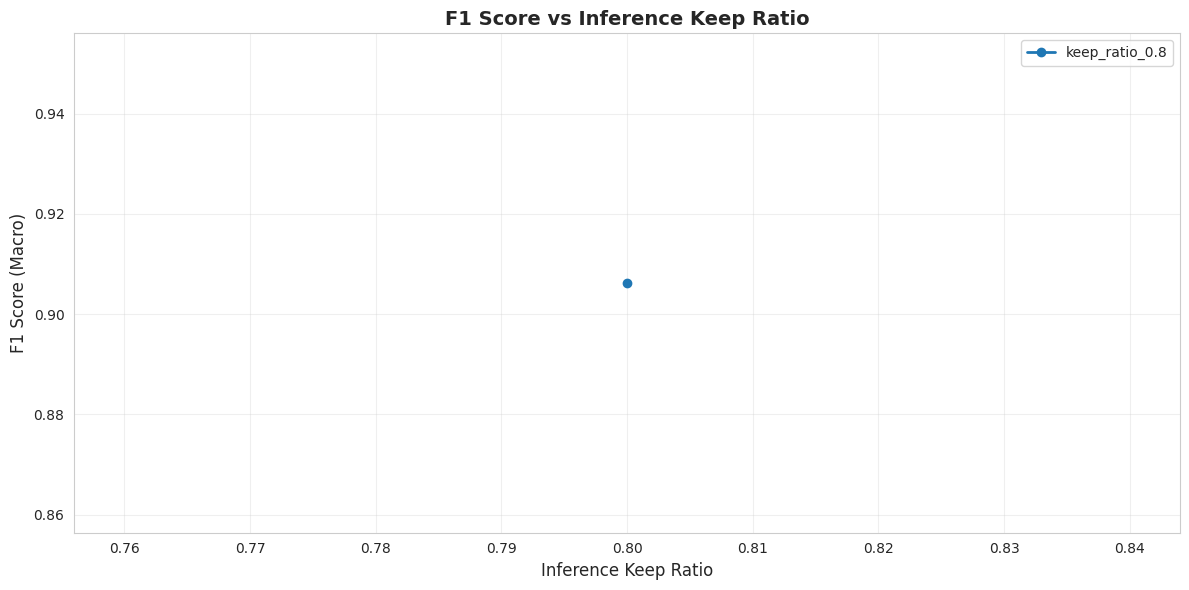

  ✅ Saved: f1_vs_keep_ratio.png


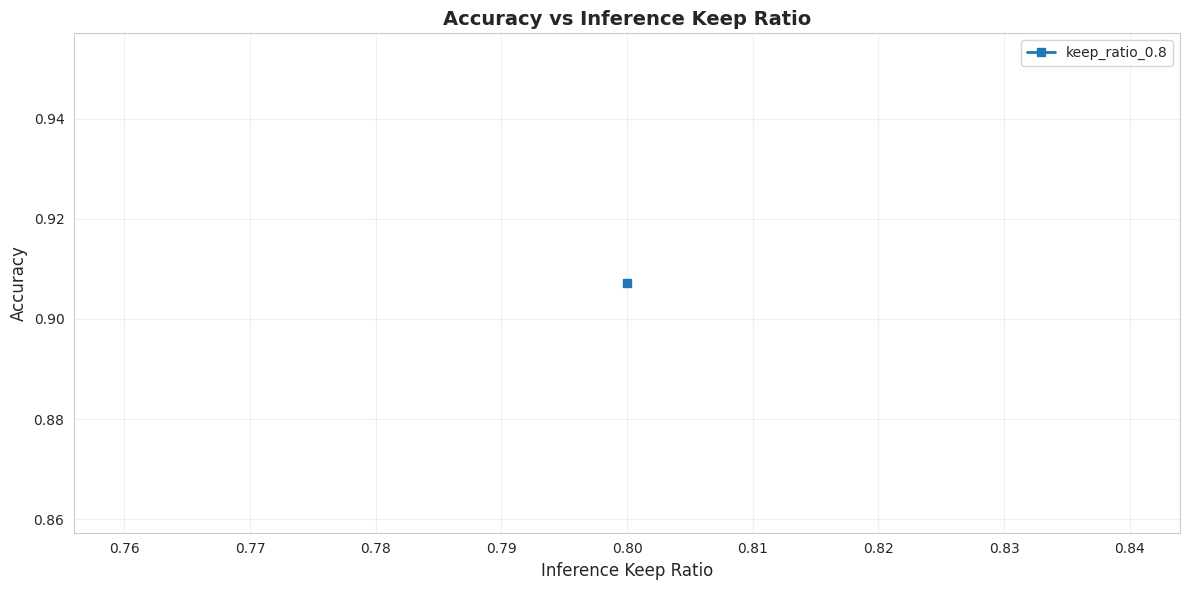

  ✅ Saved: accuracy_vs_keep_ratio.png


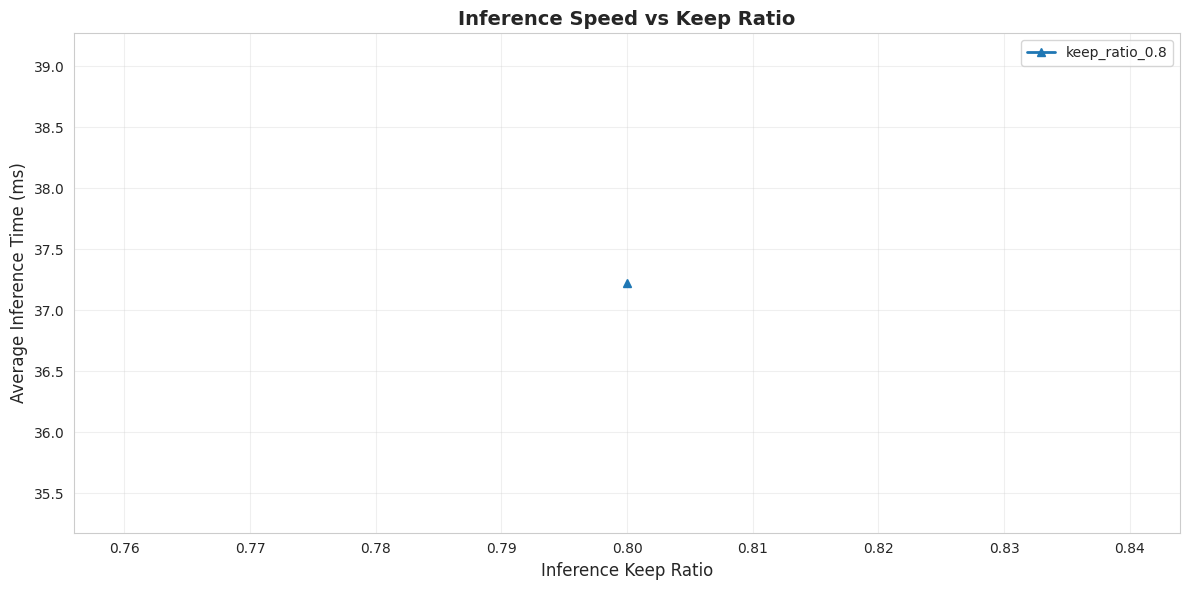

  ✅ Saved: speed_vs_keep_ratio.png


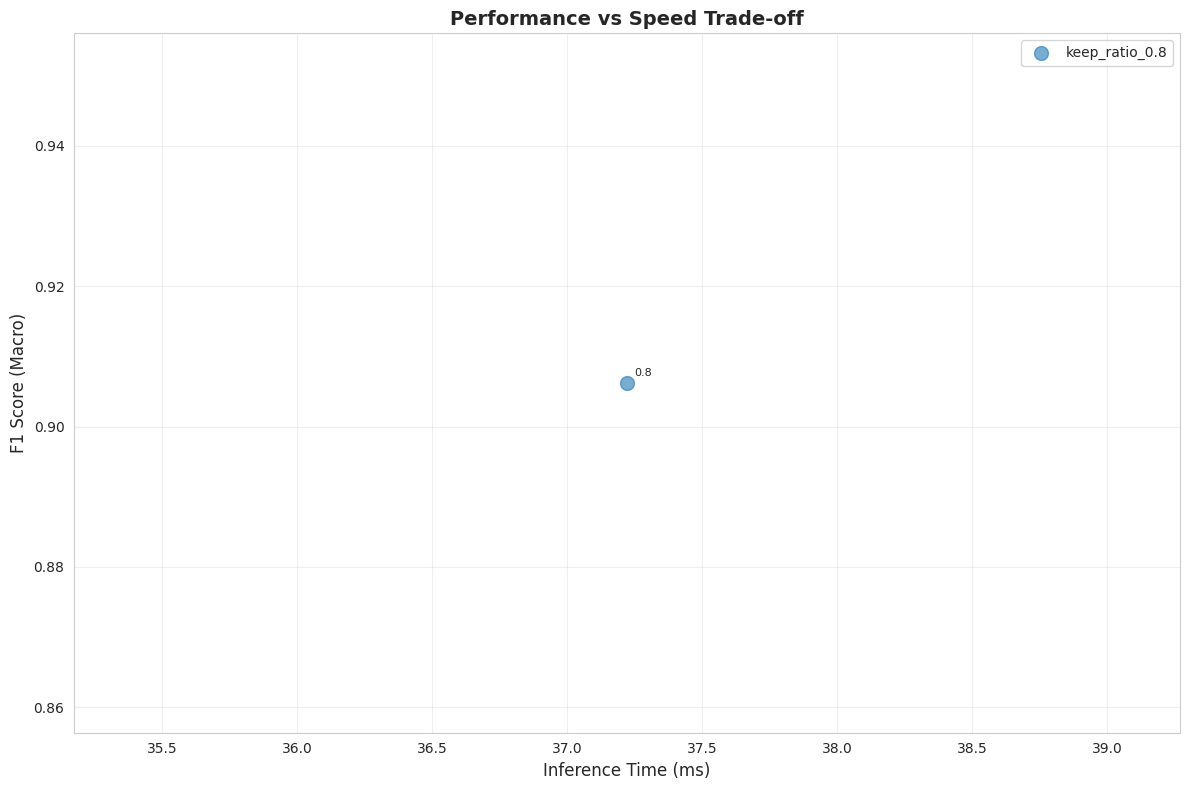

  ✅ Saved: pareto_f1_vs_speed.png


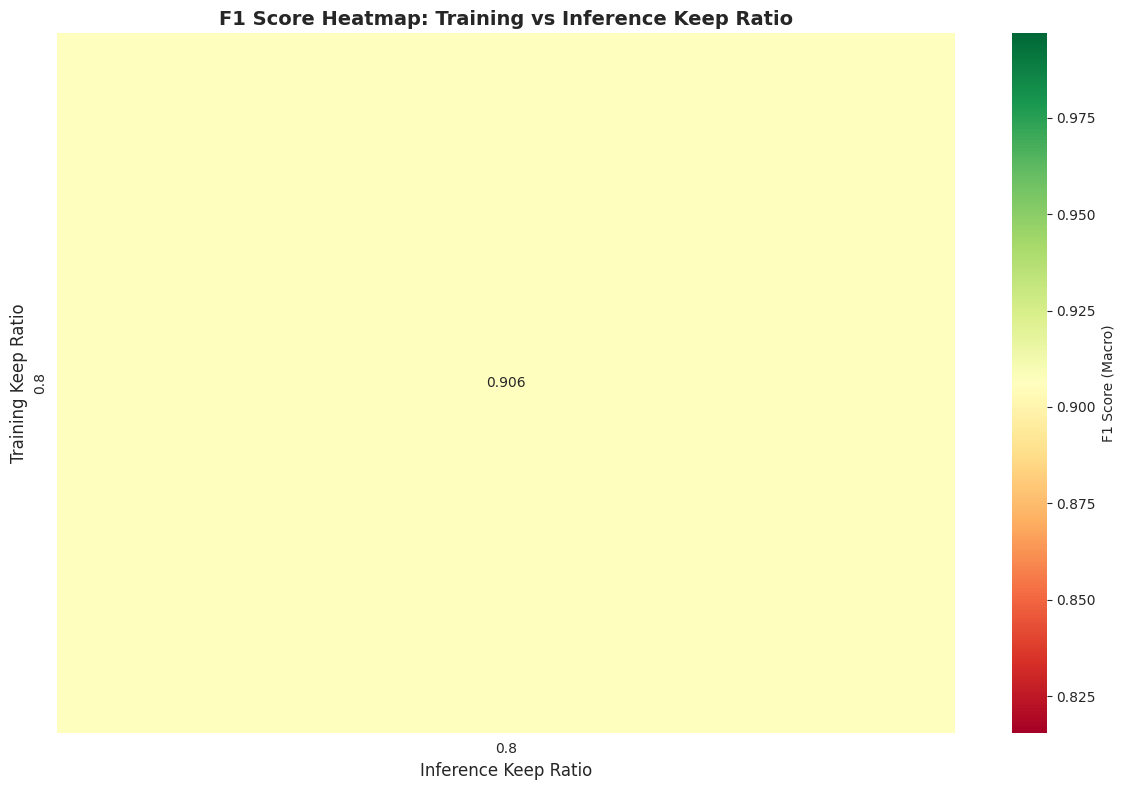

  ✅ Saved: heatmap_f1.png


KeyError: 1.0

In [9]:

print("\n📈 Generating visualizations...")

# 1. F1 Score vs Inference Keep Ratio (per ogni checkpoint)
fig, ax = plt.subplots(figsize=(12, 6))
for checkpoint_name in df_results['checkpoint'].unique():
    data = df_results[df_results['checkpoint'] == checkpoint_name]
    ax.plot(data['inference_keep_ratio'], data['f1_macro'], 
            marker='o', label=checkpoint_name, linewidth=2)

ax.set_xlabel('Inference Keep Ratio', fontsize=12)
ax.set_ylabel('F1 Score (Macro)', fontsize=12)
ax.set_title('F1 Score vs Inference Keep Ratio', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / "f1_vs_keep_ratio.png", dpi=300, bbox_inches='tight')
plt.show()
print("  ✅ Saved: f1_vs_keep_ratio.png")

# 2. Accuracy vs Inference Keep Ratio
fig, ax = plt.subplots(figsize=(12, 6))
for checkpoint_name in df_results['checkpoint'].unique():
    data = df_results[df_results['checkpoint'] == checkpoint_name]
    ax.plot(data['inference_keep_ratio'], data['accuracy'], 
            marker='s', label=checkpoint_name, linewidth=2)

ax.set_xlabel('Inference Keep Ratio', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Accuracy vs Inference Keep Ratio', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / "accuracy_vs_keep_ratio.png", dpi=300, bbox_inches='tight')
plt.show()
print("  ✅ Saved: accuracy_vs_keep_ratio.png")

# 3. Inference Speed vs Keep Ratio
fig, ax = plt.subplots(figsize=(12, 6))
for checkpoint_name in df_results['checkpoint'].unique():
    data = df_results[df_results['checkpoint'] == checkpoint_name]
    ax.plot(data['inference_keep_ratio'], data['avg_time_ms'], 
            marker='^', label=checkpoint_name, linewidth=2)

ax.set_xlabel('Inference Keep Ratio', fontsize=12)
ax.set_ylabel('Average Inference Time (ms)', fontsize=12)
ax.set_title('Inference Speed vs Keep Ratio', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / "speed_vs_keep_ratio.png", dpi=300, bbox_inches='tight')
plt.show()
print("  ✅ Saved: speed_vs_keep_ratio.png")

# 4. Trade-off: F1 vs Speed (Pareto frontier)
fig, ax = plt.subplots(figsize=(12, 8))
for checkpoint_name in df_results['checkpoint'].unique():
    data = df_results[df_results['checkpoint'] == checkpoint_name]
    scatter = ax.scatter(data['avg_time_ms'], data['f1_macro'], 
                        s=100, alpha=0.6, label=checkpoint_name)
    
    # Annota alcuni punti chiave
    for _, row in data.iterrows():
        if row['inference_keep_ratio'] in [0.3, 0.5, 0.8, 1.0]:
            ax.annotate(f"{row['inference_keep_ratio']:.1f}", 
                       (row['avg_time_ms'], row['f1_macro']),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

ax.set_xlabel('Inference Time (ms)', fontsize=12)
ax.set_ylabel('F1 Score (Macro)', fontsize=12)
ax.set_title('Performance vs Speed Trade-off', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / "pareto_f1_vs_speed.png", dpi=300, bbox_inches='tight')
plt.show()
print("  ✅ Saved: pareto_f1_vs_speed.png")

# 5. Heatmap: F1 Score (Training Ratio vs Inference Ratio)
pivot_f1 = df_results.pivot_table(
    values='f1_macro',
    index='training_keep_ratio',
    columns='inference_keep_ratio'
)

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pivot_f1, annot=True, fmt='.3f', cmap='RdYlGn', 
            cbar_kws={'label': 'F1 Score (Macro)'}, ax=ax)
ax.set_xlabel('Inference Keep Ratio', fontsize=12)
ax.set_ylabel('Training Keep Ratio', fontsize=12)
ax.set_title('F1 Score Heatmap: Training vs Inference Keep Ratio', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / "heatmap_f1.png", dpi=300, bbox_inches='tight')
plt.show()
print("  ✅ Saved: heatmap_f1.png")

# 6. Heatmap: Speedup Ratio
pivot_speed = df_results.pivot_table(
    values='avg_time_ms',
    index='training_keep_ratio',
    columns='inference_keep_ratio'
)

# Calcola speedup rispetto a keep_ratio=1.0
baseline_speed = pivot_speed[1.0]
speedup = pivot_speed.divide(baseline_speed, axis=0)

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(speedup, annot=True, fmt='.2f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'Speed Ratio (vs keep_ratio=1.0)'}, ax=ax)
ax.set_xlabel('Inference Keep Ratio', fontsize=12)
ax.set_ylabel('Training Keep Ratio', fontsize=12)
ax.set_title('Inference Speed Ratio: Training vs Inference Keep Ratio', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / "heatmap_speed_ratio.png", dpi=300, bbox_inches='tight')
plt.show()
print("  ✅ Saved: heatmap_speed_ratio.png")

In [ ]:


# %%
# =============================================================================
# SALVA RISULTATI
# =============================================================================



# %%
# =============================================================================
# VISUALIZZAZIONI
# =============================================================================


# %%
# =============================================================================
# ANALISI STATISTICA
# =============================================================================

print("\n📊 Statistical Analysis:")

# 1. Best configuration per metric
print("\n🏆 Best Configurations:")

best_f1 = df_results.loc[df_results['f1_macro'].idxmax()]
print(f"\n  Highest F1 Score: {best_f1['f1_macro']:.4f}")
print(f"    Checkpoint: {best_f1['checkpoint']}")
print(f"    Training ratio: {best_f1['training_keep_ratio']}")
print(f"    Inference ratio: {best_f1['inference_keep_ratio']}")
print(f"    Speed: {best_f1['avg_time_ms']:.2f}ms")

best_speed = df_results.loc[df_results['avg_time_ms'].idxmin()]
print(f"\n  Fastest Inference: {best_speed['avg_time_ms']:.2f}ms")
print(f"    Checkpoint: {best_speed['checkpoint']}")
print(f"    Training ratio: {best_speed['training_keep_ratio']}")
print(f"    Inference ratio: {best_speed['inference_keep_ratio']}")
print(f"    F1 Score: {best_speed['f1_macro']:.4f}")

# 2. Best trade-off (F1 > 0.9 * max_f1 and fastest)
f1_threshold = df_results['f1_macro'].max() * 0.95
candidates = df_results[df_results['f1_macro'] >= f1_threshold]
best_tradeoff = candidates.loc[candidates['avg_time_ms'].idxmin()]

print(f"\n  Best Trade-off (F1 ≥ 95% of max):")
print(f"    F1 Score: {best_tradeoff['f1_macro']:.4f}")
print(f"    Speed: {best_tradeoff['avg_time_ms']:.2f}ms")
print(f"    Checkpoint: {best_tradeoff['checkpoint']}")
print(f"    Training ratio: {best_tradeoff['training_keep_ratio']}")
print(f"    Inference ratio: {best_tradeoff['inference_keep_ratio']}")
print(f"    Speedup vs baseline: {df_results[df_results['inference_keep_ratio']==1.0]['avg_time_ms'].mean() / best_tradeoff['avg_time_ms']:.2f}x")

# 3. Performance degradation analysis
print("\n📉 Performance Degradation Analysis:")
for checkpoint_name in df_results['checkpoint'].unique():
    data = df_results[df_results['checkpoint'] == checkpoint_name].sort_values('inference_keep_ratio')
    max_f1 = data['f1_macro'].max()
    min_f1 = data['f1_macro'].min()
    degradation = (max_f1 - min_f1) / max_f1 * 100
    
    print(f"\n  {checkpoint_name}:")
    print(f"    Max F1: {max_f1:.4f} (at ratio={data.loc[data['f1_macro'].idxmax(), 'inference_keep_ratio']:.1f})")
    print(f"    Min F1: {min_f1:.4f} (at ratio={data.loc[data['f1_macro'].idxmin(), 'inference_keep_ratio']:.1f})")
    print(f"    Degradation: {degradation:.2f}%")

# %%
# =============================================================================
# MATRICE DI CONFRONTO TRAINING VS INFERENCE
# =============================================================================

print("\n📊 Generating Training vs Inference Comparison Matrix...")

# Per ogni checkpoint, confronta performance quando training_ratio == inference_ratio vs diversi
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, checkpoint_name in enumerate(df_results['checkpoint'].unique()[:4]):
    data = df_results[df_results['checkpoint'] == checkpoint_name]
    training_ratio = data['training_keep_ratio'].iloc[0]
    
    # Performance quando inference_ratio == training_ratio
    matched = data[data['inference_keep_ratio'] == training_ratio]['f1_macro'].values[0]
    
    # Performance con altri ratio
    ax = axes[idx]
    bars = ax.bar(data['inference_keep_ratio'], data['f1_macro'], alpha=0.7)
    
    # Colora la barra corrispondente al training ratio
    matched_idx = data[data['inference_keep_ratio'] == training_ratio].index[0] - data.index[0]
    bars[matched_idx].set_color('red')
    bars[matched_idx].set_alpha(1.0)
    
    ax.axhline(y=matched, color='red', linestyle='--', alpha=0.5, 
               label=f'Training ratio = {training_ratio}')
    ax.set_xlabel('Inference Keep Ratio', fontsize=10)
    ax.set_ylabel('F1 Score', fontsize=10)
    ax.set_title(f'{checkpoint_name}\n(trained with ratio={training_ratio})', 
                 fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / "training_vs_inference_comparison.png", 
            dpi=300, bbox_inches='tight')
plt.show()
print("  ✅ Saved: training_vs_inference_comparison.png")

# %%
print("\n" + "="*80)
print("✅ BENCHMARK COMPLETE!")
print("="*80)
print(f"\n📁 All results saved to: {config.OUTPUT_DIR}")
print(f"   - benchmark_results.csv")
print(f"   - benchmark_results.json")
print(f"   - 7 visualization plots")
print("\n🎉 Done!")